In [2]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

/tmp/ipykernel_745200/3287976922.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-08/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-08/data/train/outputs_json"
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [4]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [5]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [6]:
pngs = sorted(pngs)
jsons = sorted(jsons)

In [7]:
jsons

['ID001/image1661130828152_R.json',
 'ID001/image1661130891365_L.json',
 'ID002/image1661144206667.json',
 'ID002/image1661144246917.json',
 'ID003/image1661144310162.json',
 'ID003/image1661144351691.json',
 'ID004/image1661144691792.json',
 'ID004/image1661144724044.json',
 'ID005/image1661144825412.json',
 'ID005/image1661144852117.json',
 'ID006/image1661145075929.json',
 'ID006/image1661145103549.json',
 'ID007/image1661145193855.json',
 'ID007/image1661145229731.json',
 'ID008/image1661145286692.json',
 'ID008/image1661145313061.json',
 'ID009/image1661145407161.json',
 'ID009/image1661145432967.json',
 'ID010/image1661145563354.json',
 'ID010/image1661145591320.json',
 'ID011/image1661146664360.json',
 'ID011/image1661146685158.json',
 'ID012/image1661147072358.json',
 'ID012/image1661147098202.json',
 'ID013/image1661216747360.json',
 'ID013/image1661216788592.json',
 'ID014/image1661216876670.json',
 'ID014/image1661216907060.json',
 'ID015/image1661216971933.json',
 'ID015/im

## 클래스별 pixel 차지 평균 비율 

In [30]:
# label 파일을 읽습니다.
class_ratios = []
for json_file in jsons:
    label_path = os.path.join(LABEL_ROOT, json_file)
    label_shape = tuple((2048, 2048)) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    with open(label_path, "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    class_ratio = [0] * len(CLASSES)
    total = 0

    # 클래스 별로 처리합니다.
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        class_label = np.zeros((2048, 2048), dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        total += np.sum(class_label)
        class_ratio[class_ind] = np.sum(class_label)
    
    class_ratio = list(map(lambda x : x / total, class_ratio))
    print(class_ratio)
    class_ratios.append(class_ratio)

class_ratios = np.mean(class_ratios, axis = 0)
print(class_ratios)

[0.015411352718846416, 0.0304430085876579, 0.052656359162844384, 0.011180444961314316, 0.01967914531323905, 0.0405429447985871, 0.06635582151210473, 0.013734177489834973, 0.02643991894014676, 0.047952457614983054, 0.062159628895147256, 0.013421741224663372, 0.022757944342950875, 0.040048254045398725, 0.04793293034840983, 0.007747985436998529, 0.010000130181777155, 0.02486688913285918, 0.043027247045958505, 0.01669364322382153, 0.009683354524033726, 0.0293972149778474, 0.020074030037275384, 0.018485812355986408, 0.014682334766779347, 0.015949437397753063, 0.010334263409807896, 0.1706205765316971, 0.09772095102127604]
[0.015233720116695049, 0.03284358375245865, 0.055931778279408075, 0.010215767032328753, 0.020613045027919687, 0.04374909244518369, 0.070073132417198, 0.011430240386519346, 0.02537028236505485, 0.0488429501141869, 0.06342983116180217, 0.012091930352593297, 0.022954536454001823, 0.041932332712895856, 0.0491927712433831, 0.008055786569508798, 0.014699087824904625, 0.0308717146

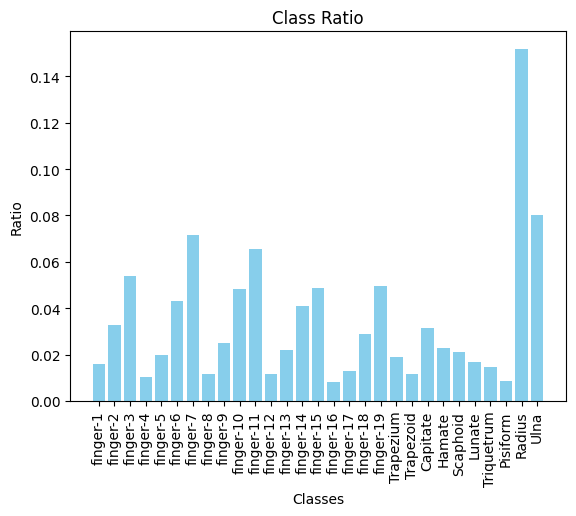

In [34]:
import matplotlib.pyplot as plt

# Bar plot 그리기
plt.bar(CLASSES, class_ratios, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Classes')
plt.ylabel('Ratio')
plt.title('Class Ratio')

# 그래프 표시
plt.show()

## multi label 분석

ID001/image1661130828152_R.json
Lunate & Radius {(954, 1432)}
ID001/image1661130828152_R.json
Radius & Scaphoid {(885, 1418), (950, 1430)}
ID001/image1661130828152_R.json
Trapezoid & finger-7 {(912, 1248)}
ID001/image1661130828152_R.json
finger-15 & finger-19 {(1059, 1243)}
ID002/image1661144206667.json
Radius & Scaphoid {(908, 1573)}
ID002/image1661144246917.json
Capitate & finger-11 {(1007, 1409)}
ID002/image1661144246917.json
Radius & Scaphoid {(1031, 1606)}
ID002/image1661144246917.json
Radius & Ulna {(961, 1716), (955, 1675), (961, 1715), (955, 1674), (961, 1717)}
ID003/image1661144310162.json
Radius & Scaphoid {(933, 1458), (884, 1431), (963, 1470)}
ID003/image1661144310162.json
Radius & Ulna {(1041, 1548), (1042, 1559), (1041, 1547), (1042, 1558), (1042, 1557)}
ID003/image1661144351691.json
Lunate & Radius {(1062, 1539), (1033, 1555)}
ID003/image1661144351691.json
Pisiform & Triquetrum {(926, 1524)}
ID003/image1661144351691.json
Radius & Scaphoid {(1111, 1525), (1145, 1510)}
ID0

ID006/image1661145103549.json
Radius & Scaphoid {(1084, 1517)}
ID006/image1661145103549.json
finger-10 & finger-9 {(1012, 603)}
ID007/image1661145193855.json
Hamate & Lunate {(1043, 1537)}
ID007/image1661145193855.json
Radius & Scaphoid {(906, 1565)}
ID007/image1661145193855.json
Radius & Ulna {(1047, 1677), (1047, 1678), (1056, 1643)}
ID008/image1661145286692.json
Radius & Scaphoid {(925, 1462)}
ID008/image1661145286692.json
Radius & Ulna {(1074, 1598), (1089, 1567)}
ID008/image1661145286692.json
Trapezoid & finger-7 {(930, 1344)}
ID008/image1661145313061.json
Hamate & Triquetrum {(932, 1518)}
ID008/image1661145313061.json
Radius & Scaphoid {(1004, 1593)}
ID008/image1661145313061.json
Radius & Ulna {(951, 1682), (938, 1650), (938, 1651), (951, 1681)}
ID009/image1661145407161.json
Lunate & Radius {(1071, 1568)}
ID009/image1661145407161.json
finger-11 & finger-7 {(973, 1350), (966, 1320)}
ID009/image1661145407161.json
finger-18 & finger-19 {(1250, 1059)}
ID009/image1661145407161.json
fi

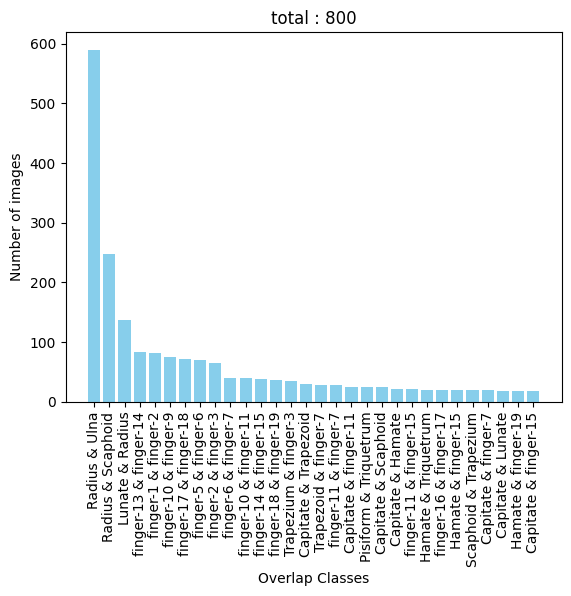

In [31]:
import json

intersections = {}

for json_file in jsons:
    label_path = os.path.join(LABEL_ROOT, json_file)
    label_shape = tuple((2048, 2048)) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    with open(label_path, "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]
    annotations = sorted(annotations, key = lambda x: x['label'])

    # 클래스 별로 처리합니다.
    for idx_ann, ann in enumerate(annotations):
        for ann_next in annotations[idx_ann+1:]:
            points = [tuple(point) for point in ann['points']]
            points_next = [tuple(point) for point in ann_next['points']]
            intersection_num = len(set(points) & set(points_next))
            if intersection_num>0:
                intersection_name = f"{ann['label']} & {ann_next['label']}"
                print(json_file)
                print(intersection_name, set(points) & set(points_next))
                if intersection_name in intersections.keys():
                    intersections[intersection_name] += 1
                else:
                    intersections[intersection_name] = 1

intersections = dict(sorted(intersections.items(), key = lambda x:x[1], reverse = True))
limit = 30
key = list(intersections.keys())[:limit]
value = list(intersections.values())[:limit]
print(len(jsons))

# Bar plot 그리기
plt.bar(key, value, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Overlap Classes')
plt.ylabel('Number of images')
plt.title(f'total : {len(jsons)}')

# 그래프 표시
plt.show()

800


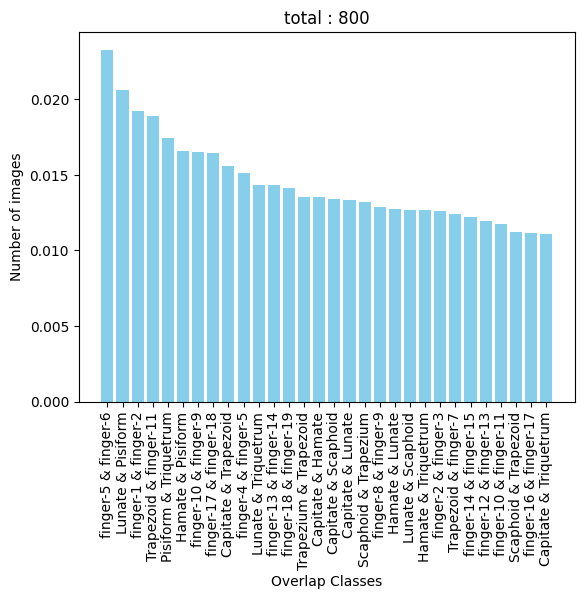

In [10]:
import json

intersections = {}

for json_file in jsons:
    label_path = os.path.join(LABEL_ROOT, json_file)
    label_shape = tuple((2048, 2048)) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    with open(label_path, "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]
    annotations = sorted(annotations, key = lambda x: x['label'])

    # 클래스 별로 처리합니다.
    for idx_ann, ann in enumerate(annotations):
        for ann_next in annotations[idx_ann+1:]:
            points = [tuple(point) for point in ann['points']]
            points_next = [tuple(point) for point in ann_next['points']]
            intersection_cnt = len(set(points) & set(points_next))
            if intersection_cnt>0:
                intersection_name = f"{ann['label']} & {ann_next['label']}"
                intersection_ratio = intersection_cnt / len(set(points) | set(points_next))
                if intersection_name in intersections.keys():
                    intersections[intersection_name].append(intersection_ratio)
                else:
                    intersections[intersection_name] = [intersection_ratio]

intersections = {k:np.mean(v) for k, v in intersections.items()}
intersections = dict(sorted(intersections.items(), key = lambda x:x[1], reverse = True))
limit = 30
key = list(intersections.keys())[:limit]
value = list(intersections.values())[:limit]
print(len(jsons))

# Bar plot 그리기
plt.bar(key, value, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Overlap Classes')
plt.ylabel('Number of images')
plt.title(f'total : {len(jsons)}')

# 그래프 표시
plt.show()

## train 이미지 가시화

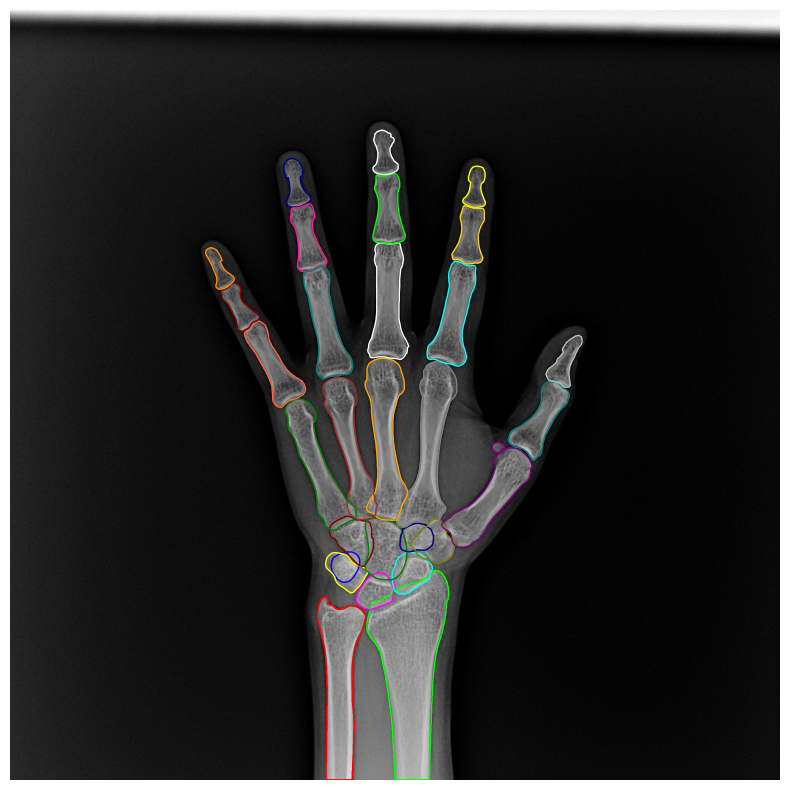

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [26]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import os

# JSON 파일과 이미지 경로
json_path = '/data/ephemeral/home/level2-cv-semanticsegmentation-cv-08/data/train/outputs_json'
source = '/data/ephemeral/home/level2-cv-semanticsegmentation-cv-08/data/train/DCM'
img= 'ID005'
colors_dict = {
    "0": (255, 0, 0),     # Red
    "1": (0, 255, 0),     # Green
    "2": (0, 0, 255),     # Blue
    "3": (255, 255, 0),   # Yellow
    "4": (255, 0, 255),   # Magenta
    "5": (0, 255, 255),   # Cyan
    "6": (128, 0, 0),     # Maroon
    "7": (0, 128, 0),     # Green (Lime)
    "8": (0, 0, 128),     # Navy
    "9": (128, 128, 0),   # Olive
    "10": (128, 0, 128),  # Purple
    "11": (0, 128, 128),  # Teal
    "12": (192, 192, 192),# Silver
    "13": (128, 128, 128),# Gray
    "14": (255, 165, 0),  # Orange
    "15": (165, 42, 42),  # Brown
    "16": (0, 128, 0),    # Green (Forest Green)
    "17": (255, 99, 71),  # Tomato
    "18": (128, 0, 0),    # Red (Maroon)
    "19": (255, 140, 0),  # Dark Orange
    "20": (0, 0, 128),    # Blue (Navy)
    "21": (255, 20, 147), # Deep Pink
    "22": (0, 125,125),      # 청록
    "23": (255, 255, 255),# White
    "24": (0, 255, 0),    # Lime
    "25": (255, 255, 255),# White
    "26": (255, 255, 0),  # Yellow (Gold)
    "27": (255, 215, 0),  # Gold
    "28": (0, 255, 255),  # Aqua
}

def min_max_normalize_rgb(rgb_tuple):
    normalized_rgb = tuple(component / 255 for component in rgb_tuple)
    return normalized_rgb

count = [0]*29
source = os.path.join(source,img)
img_file = os.listdir(source)

source = os.path.join(source,img_file[0])

json_path = os.path.join(json_path,img)
file = os.listdir(json_path)
json_path = os.path.join(json_path,file[0])

# # JSON 파일을 읽어 이미지 경로를 가져옵니다.
with open(json_path, 'r') as file:
    data = json.load(file)
    image_path = data['annotations']

# 이미지를 불러옵니다.
img = Image.open(source).convert('RGB')

# 이미지를 시각화합니다.
plt.figure(figsize=(12,10))
plt.imshow(img)
for j,i in enumerate(image_path):
    A = i['points']
    # poly = patches.Polygon(A,closed=True, edgecolor=min_max_normalize_rgb(colors_dict[str(j)]), facecolor=min_max_normalize_rgb(colors_dict[str(j)]))
    poly = patches.Polygon(A,closed=True, edgecolor=min_max_normalize_rgb(colors_dict[str(j)]), facecolor="None")
    
    

    plt.gca().add_patch(poly)
    count[j] += 1

plt.axis('off')  # 축을 숨깁니다.
plt.show()
print(count)

## train, text t-SNE

In [7]:
TEST_IMAGE_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-08/data/test/DCM"
test_pngs = {
    os.path.relpath(os.path.join(root, fname), start=TEST_IMAGE_ROOT)
    for root, _dirs, files in os.walk(TEST_IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
test_pngs = sorted(test_pngs)

In [9]:
test_pngs

['ID040/image1661319116107.png',
 'ID040/image1661319145363.png',
 'ID041/image1661319356239.png',
 'ID041/image1661319390106.png',
 'ID042/image1661320372752.png',
 'ID042/image1661320397148.png',
 'ID043/image1661320538919.png',
 'ID043/image1661320557045.png',
 'ID044/image1661320671343.png',
 'ID044/image1661320722689.png',
 'ID045/image1661320864475.png',
 'ID045/image1661320892395.png',
 'ID046/image1661320944318.png',
 'ID046/image1661320972355.png',
 'ID047/image1661389291522.png',
 'ID047/image1661389310383.png',
 'ID048/image1661389524954.png',
 'ID048/image1661389553713.png',
 'ID049/image1661389595277.png',
 'ID049/image1661389621012.png',
 'ID068/image1661735854451.png',
 'ID068/image1661735882043.png',
 'ID137/image1662340967509.png',
 'ID137/image1662340984526.png',
 'ID138/image1662341048902.png',
 'ID138/image1662341087474.png',
 'ID139/image1662341167750.png',
 'ID139/image1662341205574.png',
 'ID140/image1662341263517.png',
 'ID140/image1662341292950.png',
 'ID141/im

In [25]:
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Train 데이터셋 로드
train_dataset = datasets.ImageFolder(root=IMAGE_ROOT, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)

# Validation 데이터셋 로드
test_dataset = datasets.ImageFolder(root=TEST_IMAGE_ROOT, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# ResNet18 모델 불러오기 (사전 훈련된 가중치 사용)
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # 마지막 fully connected 레이어 제거
model = model.to(device)
model.eval()

# 특징 벡터 추출 함수
def extract_features(model, data_loader):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, target in data_loader:
            inputs, target = inputs.to(device), target.to(device)

            # 모델의 forward 진행
            output = model(inputs)
            features.extend(output.cpu().numpy())
            labels.extend(target.cpu().numpy())

    return np.array(features).squeeze(), np.array(labels).squeeze()

# Train 데이터셋의 특징 벡터 추출
train_features, train_labels = extract_features(model, train_data_loader)

# Validation 데이터셋의 특징 벡터 추출
test_features, test_labels = extract_features(model, test_data_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(1088, 512)


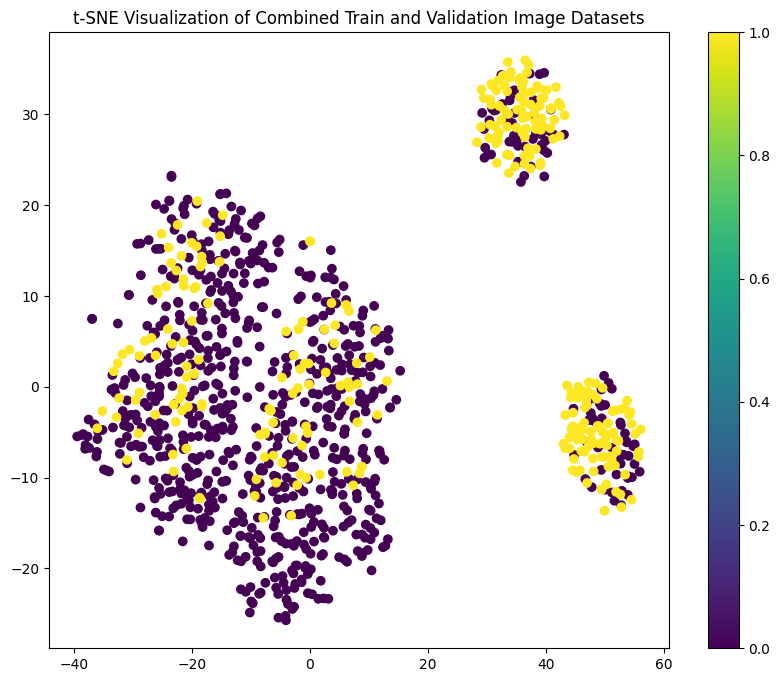

In [32]:
# t-SNE를 사용하여 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)

# Train 및 Validation 데이터셋 시각화
combined_features = np.concatenate([train_features, test_features])
print(combined_features.shape)
combined_labels = np.concatenate([np.zeros(train_labels.shape[0]), np.ones(test_labels.shape[0])])
combined_tsne = tsne.fit_transform(combined_features)

plt.figure(figsize=(10, 8))
plt.scatter(combined_tsne[:, 0], combined_tsne[:, 1], c=combined_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Combined Train and Validation Image Datasets')
plt.show()

In [8]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import os

for idx in range(len(pngs), 2):
    # JSON 파일과 이미지 경로
    json_path = '/data/ephemeral/home/level2-cv-semanticsegmentation-cv-08/data/train/outputs_json'
    source = '/data/ephemeral/home/level2-cv-semanticsegmentation-cv-08/data/train/DCM'
    img= pngs[idx][:5]
    colors_dict = {
        "0": (255, 0, 0),     # Red
        "1": (0, 255, 0),     # Green
        "2": (0, 0, 255),     # Blue
        "3": (255, 255, 0),   # Yellow
        "4": (255, 0, 255),   # Magenta
        "5": (0, 255, 255),   # Cyan
        "6": (128, 0, 0),     # Maroon
        "7": (0, 128, 0),     # Green (Lime)
        "8": (0, 0, 128),     # Navy
        "9": (128, 128, 0),   # Olive
        "10": (128, 0, 128),  # Purple
        "11": (0, 128, 128),  # Teal
        "12": (192, 192, 192),# Silver
        "13": (128, 128, 128),# Gray
        "14": (255, 165, 0),  # Orange
        "15": (165, 42, 42),  # Brown
        "16": (0, 128, 0),    # Green (Forest Green)
        "17": (255, 99, 71),  # Tomato
        "18": (128, 0, 0),    # Red (Maroon)
        "19": (255, 140, 0),  # Dark Orange
        "20": (0, 0, 128),    # Blue (Navy)
        "21": (255, 20, 147), # Deep Pink
        "22": (0, 125,125),      # 청록
        "23": (255, 255, 255),# White
        "24": (0, 255, 0),    # Lime
        "25": (255, 255, 255),# White
        "26": (255, 255, 0),  # Yellow (Gold)
        "27": (255, 215, 0),  # Gold
        "28": (0, 255, 255),  # Aqua
    }

    def min_max_normalize_rgb(rgb_tuple):
        normalized_rgb = tuple(component / 255 for component in rgb_tuple)
        return normalized_rgb

    count = [0]*29
    source = os.path.join(source,img)
    img_file = os.listdir(source)

    source = os.path.join(source,img_file[0])

    json_path = os.path.join(json_path,img)
    file = os.listdir(json_path)
    json_path = os.path.join(json_path,file[0])

    # # JSON 파일을 읽어 이미지 경로를 가져옵니다.
    with open(json_path, 'r') as file:
        data = json.load(file)
        image_path = data['annotations']

    # 이미지를 불러옵니다.
    img = Image.open(source).convert('RGB')

    # 이미지를 시각화합니다.
    plt.figure(figsize=(12,10))
    plt.imshow(img)
    for j,i in enumerate(image_path):
        A = i['points']
        # poly = patches.Polygon(A,closed=True, edgecolor=min_max_normalize_rgb(colors_dict[str(j)]), facecolor=min_max_normalize_rgb(colors_dict[str(j)]))
        poly = patches.Polygon(A,closed=True, edgecolor=min_max_normalize_rgb(colors_dict[str(j)]), facecolor="None")
        
        

        plt.gca().add_patch(poly)
        count[j] += 1

    plt.axis('off')  # 축을 숨깁니다.
    plt.show()
    print(count)